# Lorenz-63 model
In this Notebook we'll demonstrate how to construct multivariate models. To this end, we shall consider the Lorenz-63 model, defined as 
\begin{equation}
    \begin{cases}
        \mathrm{d}X^1_t = -S (X^1_t - X^2_t) \mathrm{d}t + \mathrm{d}W^1_t, \\
        \mathrm{d}X^2_t = (RX^1_t - X^2_t - X^1_t \cdot X^2_t) \mathrm{d}t + \mathrm{d}W^2_t, \\
        \mathrm{d}X^3_t = (X^1_t \cdot X^2_t - BX^3_t) \mathrm{d}t + \mathrm{d}W^3_t,
    \end{cases}
\end{equation}
where $\{W^i_t\}$ are 1-dimensional Wienere processes and $(S, R, B) \in \mathbb{R}^3$. We assume that we collect discrete observations of the above system via the following set of equations
\begin{equation}
    \begin{cases}
        Y^1_t = k_o X^1_t + V^1_t, \\
        Y^2_t = k_o X^3_t + V^2_t,
    \end{cases}
\end{equation}
where $k_o > 0$, and $V^i_t \sim \mathcal{N}(0, \sigma^2)$ where $\sigma^2 = 0.1$. We proceed in the same manner as the Stochastic volatility example and import the necessary packages.

In [1]:
from pyfilter.timeseries import StateSpaceModel, EulerMaruyma, Observable

Next, we define the inital distributions as
\begin{equation}
X^1_0 \sim \mathcal{N}(-5.9162, 10), \quad X^2_0 \sim \mathcal{N}(-5.52332, 10), \quad X^3_0 \sim \mathcal{N}(24.5723, 10),
\end{equation}
which means that the model equations are given by

In [2]:
import numpy as np
from pyfilter.utils.utils import dot


def finit(s, r, b):
    return [-5.91652, -5.52332, 24.5723]


def ginit(s, r, b):
    return np.sqrt(10) * np.eye(3)


def f(x, s, r, b):
    x1 = -s * (x[0] - x[1])
    x2 = r * x[0] - x[1] - x[0] * x[2]
    x3 = x[0] * x[1] - b * x[2]

    return x1, x2, x3


def g(x, s, r, b):
    return np.eye(3)


def alpha(x, ko):
    mat = np.zeros((2, x.shape[0]))
    mat[0, 0] = mat[1, 2] = ko

    return dot(mat, x)


def beta(x, ko):
    return np.eye(2) / np.sqrt(10)

For this example we'll simulate data, we do this by setting $(S, R, B) \triangleq (10, 28, 8/3)$ and run the below script

In [3]:
import matplotlib.pyplot as plt
from pyfilter.distributions.continuous import MultivariateNormal, Uniform


dt = 1e-2
mvn3 = MultivariateNormal(ndim=3)
hidden = EulerMaruyma((finit, ginit), (f, g), (10, 28, 8/3), (mvn3, mvn3), dt=dt)
obs = Observable((alpha, beta), (0.8,), MultivariateNormal(ndim=2))

simmodel = StateSpaceModel(hidden, obs)

x, y = simmodel.sample(2000)

fig, ax = plt.subplots(2, figsize=(16, 9))

ax[1].plot(x)
ax[0].plot(y)

Where the upper plot is the observble data, and the lower is the hidden processes. Next, we shall perform the inference. We use the NESS to target the parameters. However, since the model has purely additive noise (rather than multiplicative) in the observational process, we may use the `Unscented Kalman Filter` to target the latent process. Furthermore, we use the same priors as in the original paper describing the NESS algorithm. Such that we get

In [4]:
from pyfilter.filters import NESS, UKF
from time import time

hidden = EulerMaruyma((finit, ginit), (f, g), (Uniform(5, 20), Uniform(18, 50), Uniform(1, 8)), (mvn3, mvn3), dt=dt)
ssm = StateSpaceModel(hidden, obs)

start = time()
algs = list()
for i in range(3):
    algs.append(NESS(ssm.copy(), (1000,), filt=UKF, shrinkage=None, p=4).longfilter(y))
print('Took me {:.0f} seconds on average to process {:d} observations'.format((time() - start) / (i + 1), len(y)))

Took me 24 seconds on average to process 2000 observations


Next, let's plot the filtered components

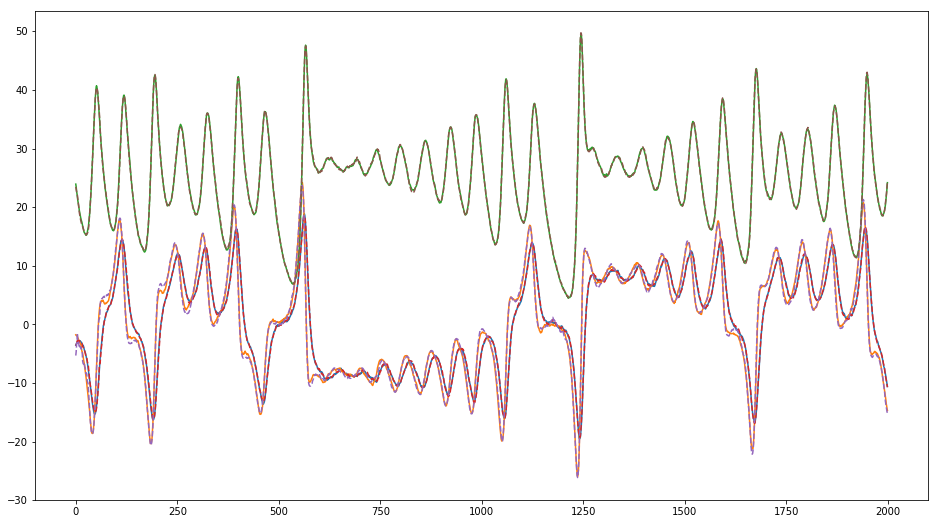

In [5]:
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(x)
ax.plot(algs[0].filtermeans(), '--')

And finally we plot the posterior distributions together with the true parameters

Run 1
	 Posterior mean and std: 9.74, 0.24
	 Posterior mean and std: 28.24, 0.31
	 Posterior mean and std: 2.67, 0.06
Run 2
	 Posterior mean and std: 9.71, 0.25
	 Posterior mean and std: 28.30, 0.33
	 Posterior mean and std: 2.67, 0.06
Run 3
	 Posterior mean and std: 9.78, 0.23
	 Posterior mean and std: 28.22, 0.30
	 Posterior mean and std: 2.67, 0.06


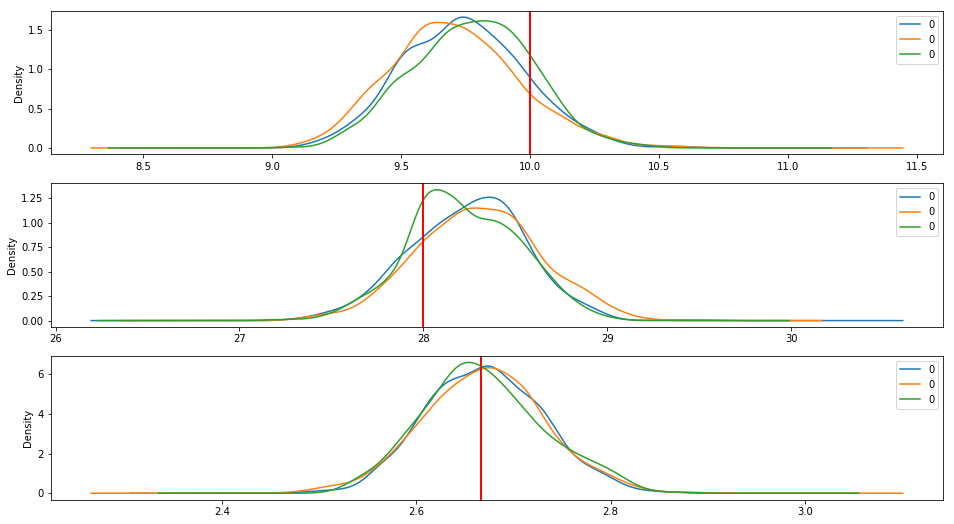

In [6]:
import pandas as pd


fig, ax = plt.subplots(3, figsize=(16, 9))

for r, alg in enumerate(algs):
    print('Run {:d}'.format(1 + r))
    
    for i, (p, ptrue) in enumerate(zip(alg.ssm.hidden.theta, simmodel.hidden.theta)):
        pd.DataFrame(p.values).plot(kind='kde', ax=ax[i])
        ax[i].axvline(ptrue, color='r')
        
        print('\t Posterior mean and std: {:.2f}, {:.2f}'.format(p.values.mean(), p.values.std()))

plt.show()